<center> <img src="https://miro.medium.com/v2/resize:fit:1250/format:webp/1*QgI1t-7yJApi4vQigFgsLQ.jpeg" width=25% > </center>

<br><br>

<center> 
    <font size="6">Final Lab (Part 1): Keypoint Detection, Bag of Visual Words and Image Classification</font>
</center>
<center> 
    <font size="4">Computer Vision 1 University of Amsterdam</font> 
</center>
<center> 
    <font size="4">Due 23:59PM, October 18, 2024 (Amsterdam time)</font> 
</center>
<center> 
    <font size="4"><b>TA's: Vlad, Matey & Antonios</b></font>
</center>

<br><br>

***

<br><br>

<center>

Student1 ID:  \
Student1 Name: 

Student2 ID: \
Student2 Name: 

Student3 ID: \
Student3 Name: 

( Student4 ID: \
Student4 Name: )

</center>

### **General Guidelines**

Your code must be handed in this Jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Final Lab (Part 1) Assignment. Please also fill out your names and IDs above.

For full credit, make sure your notebook follows these guidelines:

- Please express your thoughts **concisely**. The number of words does not necessarily correlate with how well you understand the concepts.
- Understand the problem as much as you can. When answering a question, provide evidence (qualitative and/or quantitative results, references to papers, figures, etc.) to support your arguments. Not everything might be explicitly asked for, so think about what might strengthen your arguments to make the notebook self-contained and complete.
- Tables and figures must be accompanied by a **brief** description. Add a number, a title, and, if applicable, the name and unit of variables in a table, and name and unit of axes and legends in a figure.

**Late submissions are not allowed.** Assignments submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance to avoid last-minute system failure issues.

**Environment:** Since this is a project-based assignment, you are free to use any feature descriptor and machine learning tools (e.g., K-means, SVM). You should use Python for your implementation. You are free to use any Python library for this assignment, but make sure to provide a conda environment file!

**Plagiarism Note:** Keep in mind that plagiarism (submitted materials which are not your work) is a serious offense and any misconduct will be addressed according to university regulations. This includes using generative tools such as ChatGPT.

**Ensure that you save all results/answers to the questions (even if you reuse some code).**

### **Report Preparation**

Your tasks include the following:

1. **Report Preparation:** For both parts of the final project, students are expected to prepare a report. The report should include all details on implementation approaches, analysis of results for different settings, and visualizations illustrating experiments and performance of your implementation. Grading will be based on the report, so it should be as self-contained as possible. If the report contains faulty results or ambiguities, TAs can refer to your code for clarification. Only section 10 of this notebook should **not** be included in the report.

2. **Explanation of Results:** Do not just provide numbers without explanation. Discuss different settings to show your understanding of the material and processes involved.

3. **Quantitative Evaluation:** For quantitative evaluation, you are expected to provide the results based on the mAP (mean Average Precision) metric. You should report the mAP for each experimental setup. 

4. **Qualitative Evaluation:** For qualitative evaluation, you are expected to visualize the top-5 and bottom-5 ranked test images (based on classifier confidence for the target class) per setup. Provide a figure for each experimental setup Visual elements such as charts, graphs, and plots are always useful. Keep this in mind while writing your reports.

5. **Aim:** Understand the basic Image Classification pipeline using a traditional Bag of Visual Words method.

6. **Working on Assignments:** Students should work in assigned groups for **two** weeks. Any questions can be discussed on ED.

    - **Submission:** Submit your source code and report together in a zip file (`ID1_ID2_ID3_part1.zip`). The report should be a maximum of 10 pages (single-column, including tables and figures, excluding references and appendix). Express thoughts concisely. Tables and figures must be accompanied by a description. Number them and, if applicable, name variables in tables, and label axes in figures.

7. **Hyperparameter Search:** In your experiments, remember to perform a hyperparameter search to find the optimal settings for your classifier. Clearly document the search process, the parameters you explored, and how they influenced the performance of your model.

8. **Format and Testing:** The report should be in **Pdf_combined_combined_combined_combined_combined format**, and the code in **.ipynb format**. Test that all functionality works as expected in the notebook.

### **Overview**

- [Section 1: Data Preparation (0 points)](#section-1)
- [Section 2: Keypoint Detection and Feature Extraction (3 points)](#section-2)
- [Section 3: Building the Visual Vocabulary (3 points)](#section-3)
- [Section 4: Encoding Train Image Features (3 points)](#section-4)
- [Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)](#section-5)
- [Section 6: Encoding Test Image Features (0 points)](#section-6)
- [Section 7: Training the Classifiers (5 points)](#section-7)
- [Section 8: Evaluating the Classifiers (12 points)](#section-8)
- [Section 9: Hyperparameter Search (16 points)](#section-9)
- [Section 10: Using CLIP for Image Classification (5 points)](#section-10)
- [Section X: Individual Contribution Report (Mandatory)](#section-x)

### **Section 1: Data Preparation (0 points)**

The goal of this lab is to implement an image classification system that can identify objects from a given set of classes. You will perform a 5-class image classification using a bag-of-words approach ([reference](http://www.robots.ox.ac.uk/~az/icvss08_az_bow.pdf_combined_combined_combined)). The classes for this task are:

1. **Frog**
2. **Automobile**
3. **Bird**
4. **Cat**
5. **Deer**

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) will be used for this task. This dataset contains 32x32 pixel RGB images, divided into sub-directories with 5000 training images and 1000 test images for each class.

The dataset will be automatically downloaded using the code provided in this notebook. You will need to perform training on the training set, which will later be divided into two subsets: one for building the visual vocabulary and another for training the classifier. Using more samples for training generally results in better performance. However, if computational resources are limited, you may use fewer training images to save time, as long as at least 500 images per class are included.

The system must be tested using the specified subset of test images. Use all 1000 test images (per class) to observe the full performance of the model. Ensure that test images are excluded from training to maintain a fair comparison.

In [2]:
### THIS IS CODE GIVEN BY INSTRUCTIONS ###


import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define total train and test sizes
total_train_size = 5000  # Default value for total training images
total_test_size = 1000   # Default value for total test images

# Define batch sizes for DataLoader
train_batch_size = total_train_size
test_batch_size = total_test_size

# Define the number of Visual Words
num_of_visual_words = 1000  # Default value for number of visual words

# Number of classes
num_classes = 5

# Compute images per class for training and testing
images_per_class_train = total_train_size // num_classes  # e.g., 5000 // 5 = 1000 per class
images_per_class_test = total_test_size // num_classes    # e.g., 1000 // 5 = 200 per class

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Define the class indices for the 5 selected classes: frog, automobile, bird, cat, and deer
selected_classes = [6, 1, 2, 3, 4]  # 6: frog, 1: automobile, 2: bird, 3: cat, 4: deer
class_to_label = {orig_class: new_label for new_label, orig_class in enumerate(selected_classes)}

# Load the CIFAR-10 training set
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to filter and remap dataset
def filter_dataset(dataset, images_per_class, selected_classes, class_to_label):
    selected_indices = []
    class_counts = {class_idx: 0 for class_idx in selected_classes}
    remapped_labels = []

    for idx, (image, label) in enumerate(dataset):
        if label in selected_classes and class_counts[label] < images_per_class:
            selected_indices.append(idx)
            remapped_labels.append(class_to_label[label])
            class_counts[label] += 1

            # Stop if we have enough samples for each class
            if all(count >= images_per_class for count in class_counts.values()):
                break

    filtered_dataset = Subset(dataset, selected_indices)
    return filtered_dataset, remapped_labels

# Filter and remap training set
filtered_train_set, train_mapped_labels = filter_dataset(train_set, images_per_class_train, selected_classes, class_to_label)

# Load the CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter and remap test set
filtered_test_set, test_mapped_labels = filter_dataset(test_set, images_per_class_test, selected_classes, class_to_label)

# Create data loaders for the filtered datasets
train_data_loader = DataLoader(filtered_train_set, batch_size=train_batch_size, shuffle=False)
test_data_loader = DataLoader(filtered_test_set, batch_size=test_batch_size, shuffle=False)

# Extract all training data and remapped labels
train_images, _ = next(iter(train_data_loader))
train_labels = torch.tensor(train_mapped_labels)

train_images = train_images.permute(0, 2, 3, 1)
print(f"Filtered train data: {train_images.shape}")
print(f"Filtered train labels: {train_labels.shape}")

# Extract all test data and remapped labels
test_images, _ = next(iter(test_data_loader))
test_labels = torch.tensor(test_mapped_labels)

test_images = test_images.permute(0, 2, 3, 1)
print(f"Filtered test data: {test_images.shape}")
print(f"Filtered test labels: {test_labels.shape}")

Files already downloaded and verified
Files already downloaded and verified
Filtered train data: torch.Size([5000, 32, 32, 3])
Filtered train labels: torch.Size([5000])
Filtered test data: torch.Size([1000, 32, 32, 3])
Filtered test labels: torch.Size([1000])


<a id="section-2"></a>
### **Section 2: Keypoint Detection and Feature Extraction (3 points)**

In this section, you will work on detecting keypoints and extracting features from the dataset. Your task is to use **two different feature extraction techniques** to identify keypoints in the images. Visualize two images from each of the five classes (Frog, Automobile, Bird, Cat, Deer) for both feature extraction techniques. For each image, draw circles around the detected keypoints that represent their size.

This step is essential to understand how different feature extractors behave across various classes, setting the foundation for further analysis and classification in later steps.

**Hint:** You can use the OpenCV library to detect keypoints and extract features. You can also upscale the images to improve the visualization of the keypoints.

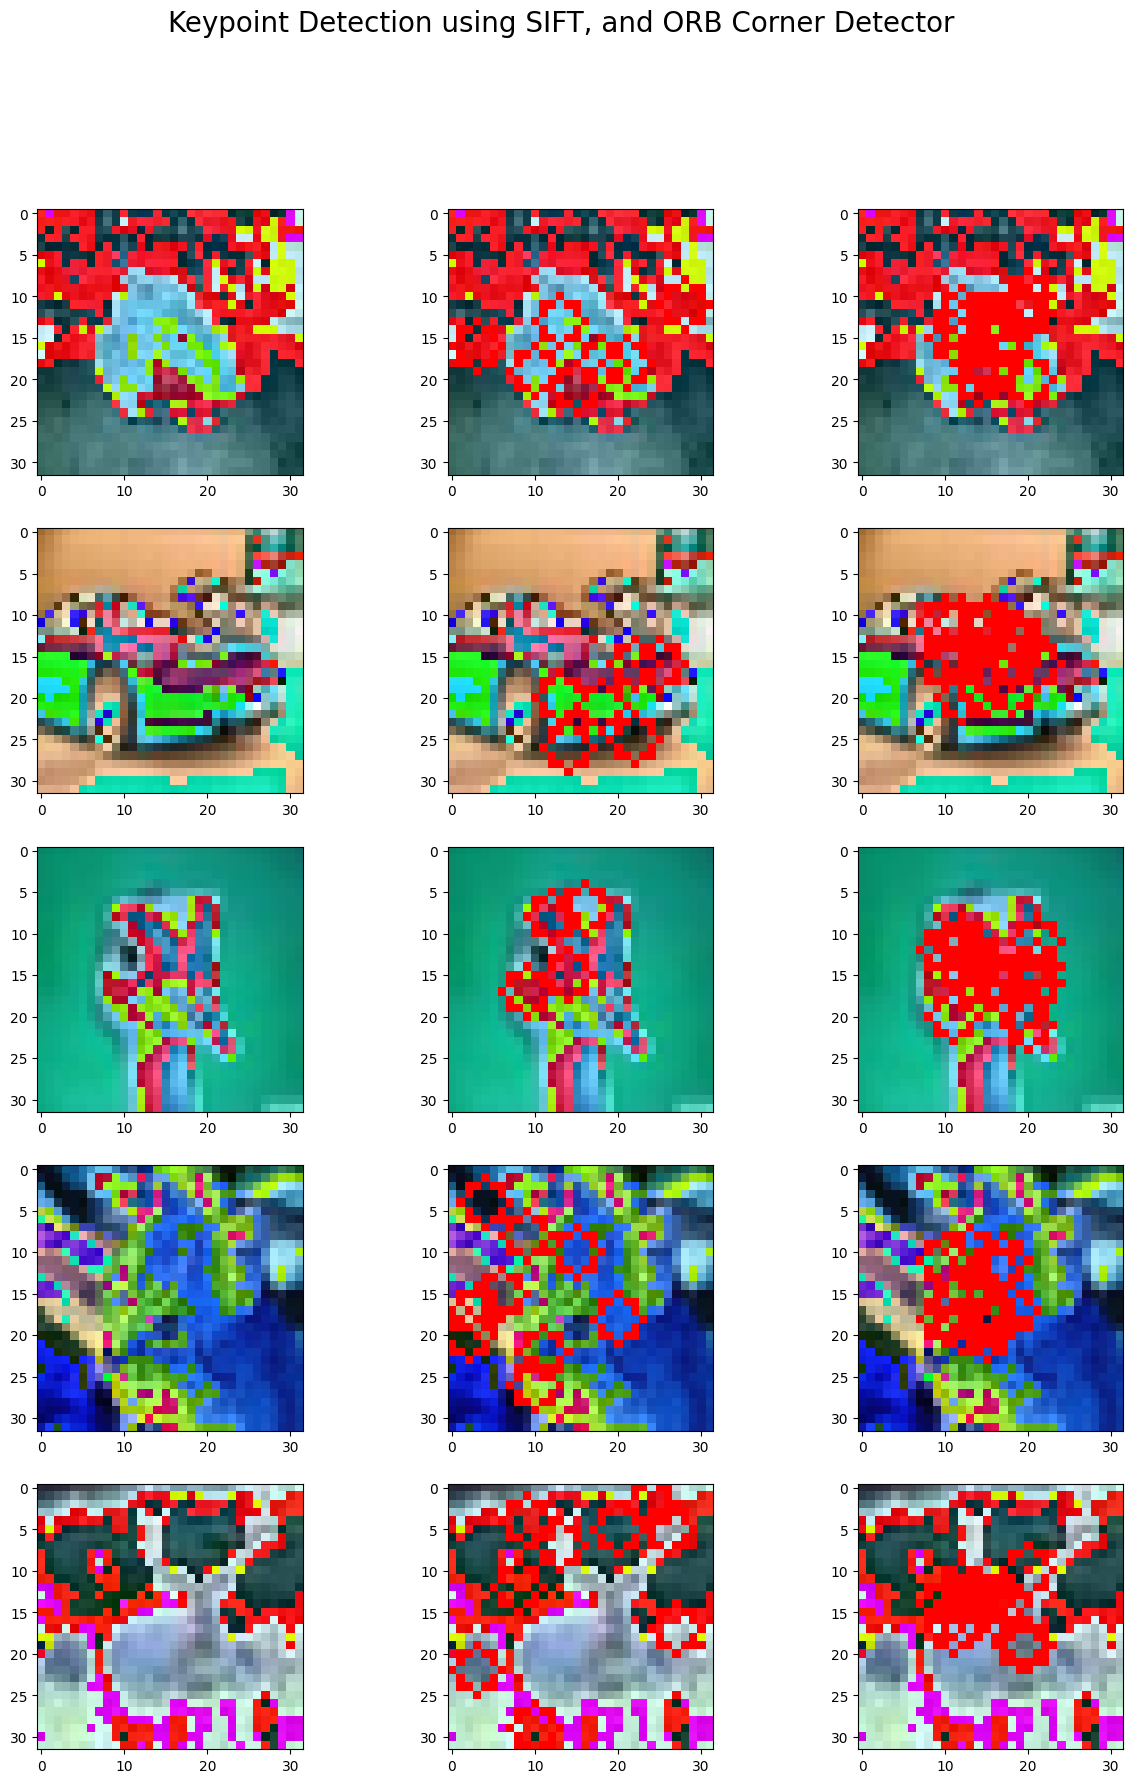

In [3]:
# HERE I TRIED SEVERAL DIFFERENT DETECTORS...HARRIS did not work properly - we might need to adjust it! :D

def detect_keypoints_sift(image):
    sift = cv2.SIFT_create(edgeThreshold=0.01)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def detect_keypoints_orb(image):
    orb = cv2.ORB_create(edgeThreshold=10)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

# drawing the key points :)
def draw_keypoints(image, keypoints, title):
    img_with_keypoints = image.copy()
    if len(keypoints) > 0:
        for kp in keypoints:
            if isinstance(kp, cv2.KeyPoint):
                cv2.circle(img_with_keypoints, (int(kp.pt[0]), int(kp.pt[1])), 3, (255, 0, 0), 1)
            else:
                cv2.circle(img_with_keypoints, (kp[1], kp[0]), 3, (255, 0, 0), 1)  
    return img_with_keypoints

# if applied multiple times the same image could be chosen twice (or more times) - adjust?
# you can choose a label e.g. Frog and then a random frog picture will be returned.
def get_random_picture(label=None):
    classes = {'Frog': 0, 'Automobile': 1, 'Bird': 2, 'Cat': 3, 'Deer': 4}
    if label is not None:
        matching_indices = [i.item() for i in torch.where(train_labels == classes[label])[0]]
        random_index = np.random.choice(matching_indices)
        return train_images[random_index].numpy(), random_index
    else:
        random_index = np.random.randint(0, train_images.shape[0])
        return train_images[random_index].numpy(), random_index

classes = ['Frog', 'Automobile', 'Bird', 'Cat', 'Deer']
images = [get_random_picture(label)[0] for label in classes]

fig, axs = plt.subplots(len(classes), 3, figsize=(15, 20))
fig.suptitle('Keypoint Detection using SIFT, and ORB Corner Detector', fontsize=20)

for i, cls in enumerate(classes):
    img = images[i]
    img = (img * 255).astype(np.uint8) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    sift_keypoints, _ = detect_keypoints_sift(img)
    orb_keypoints, _ = detect_keypoints_orb(img)

    axs[i, 0].imshow(img)
    axs[i, 1].imshow(draw_keypoints(img, sift_keypoints, f'SIFT - {cls}'))
    axs[i, 2].imshow(draw_keypoints(img, orb_keypoints, f'ORB - {cls}'))


plt.show()


<a id="section-3"></a>
### **Section 3: Building the Visual Vocabulary (3 points)**

In this section, the task is to create a visual vocabulary by clustering feature descriptors extracted from the images using K-Means. Each cluster center in this vocabulary will represent a visual word. Use the two different extraction techniques you implemented to extract descriptors from a subset of training images that includes all categories, and then apply K-Means clustering to build the vocabulary. The number of clusters is fixed at 1000, but you can experiment with different values when you are tuning the hyperparameters in section 9.

To examine the effect of different amounts of training data, build separate visual vocabularies using 30%, 40%, and 50% subsets of the training images. For faster clustering, the `faiss` library can be used, as it provides an efficient implementation of K-Means. Then, visualize the first 10 clusters for each feature extraction technique and each subset size using PCA to reduce the dimensions to 2D.

**Hints:**
1. Begin by debugging the code with a small number of input images to ensure it functions correctly before running it on larger datasets.
2. If the `faiss` library is not available, K-Means clustering can also be performed using the `sklearn` or `scipy` libraries.
3. For visualization, use PCA from `sklearn.decomposition` to reduce the high-dimensional descriptors to 2D. Display up to 10 clusters in the scatter plot to maintain clarity.

WARNING clustering 17686 points to 1000 centroids: please provide at least 39000 training points


Clustering 17686 points in 128D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (2.56 s, search 2.51 s): objective=1.21714e+09 imbalance=1.239 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (4.59 s, search 4.51 s): objective=1.21905e+09 imbalance=1.241 nsplit=0       
Outer iteration 2 / 5
  Iteration 19 (6.66 s, search 6.55 s): objective=1.22073e+09 imbalance=1.241 nsplit=0       
Outer iteration 3 / 5
  Iteration 19 (9.12 s, search 8.96 s): objective=1.2173e+09 imbalance=1.209 nsplit=0        
Outer iteration 4 / 5
  Iteration 19 (11.47 s, search 11.27 s): objective=1.21961e+09 imbalance=1.230 nsplit=0       


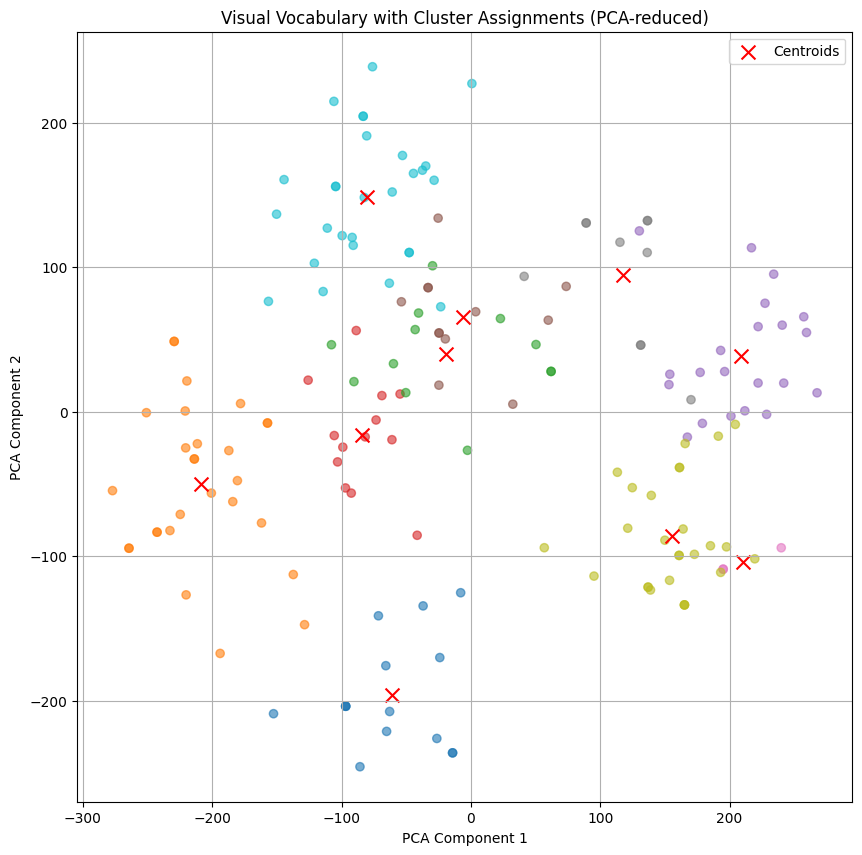

WARNING clustering 21037 points to 1000 centroids: please provide at least 39000 training points


Clustering 21037 points in 32D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (1.03 s, search 1.02 s): objective=1.7401e+09 imbalance=1.221 nsplit=0        
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (2.01 s, search 1.99 s): objective=1.73731e+09 imbalance=1.214 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (3.09 s, search 3.05 s): objective=1.738e+09 imbalance=1.197 nsplit=0         
Outer iteration 3 / 5
  Iteration 19 (4.04 s, search 3.99 s): objective=1.74021e+09 imbalance=1.217 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (5.03 s, search 4.97 s): objective=1.73849e+09 imbalance=1.217 nsplit=0       


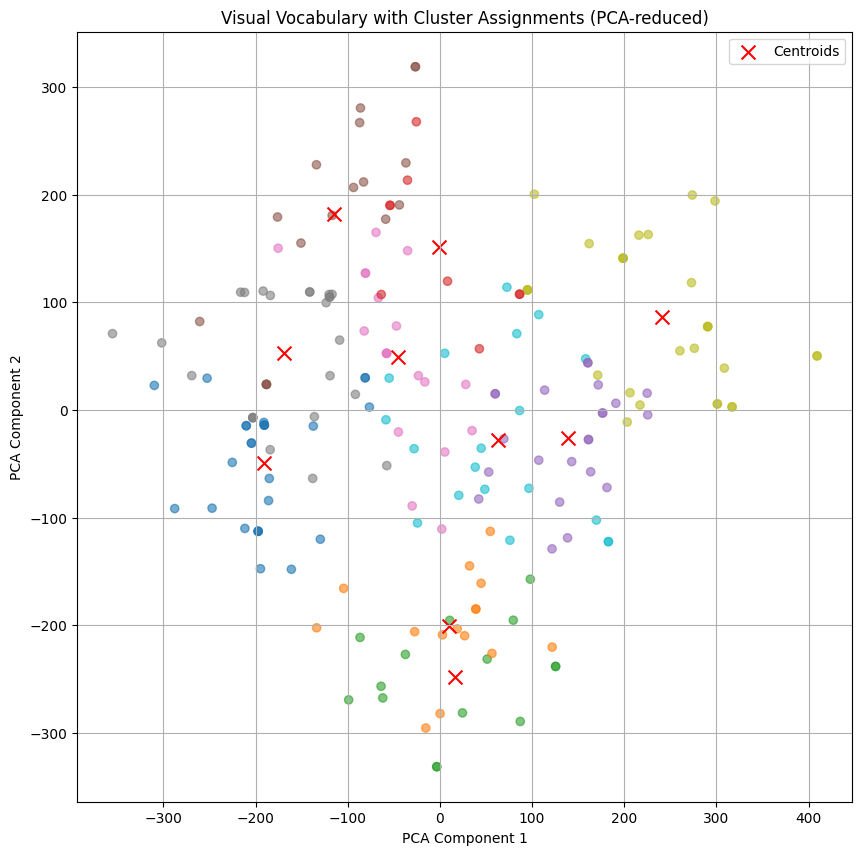

WARNING clustering 29645 points to 1000 centroids: please provide at least 39000 training points


Clustering 29645 points in 128D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.01 s
Outer iteration 0 / 5
  Iteration 19 (3.69 s, search 3.64 s): objective=2.09472e+09 imbalance=1.172 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (7.01 s, search 6.90 s): objective=2.09674e+09 imbalance=1.170 nsplit=0       
Outer iteration 2 / 5
  Iteration 19 (10.30 s, search 10.15 s): objective=2.09321e+09 imbalance=1.159 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 19 (13.36 s, search 13.16 s): objective=2.09823e+09 imbalance=1.165 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (16.50 s, search 16.27 s): objective=2.09216e+09 imbalance=1.168 nsplit=0       
Objective improved: keep new clusters


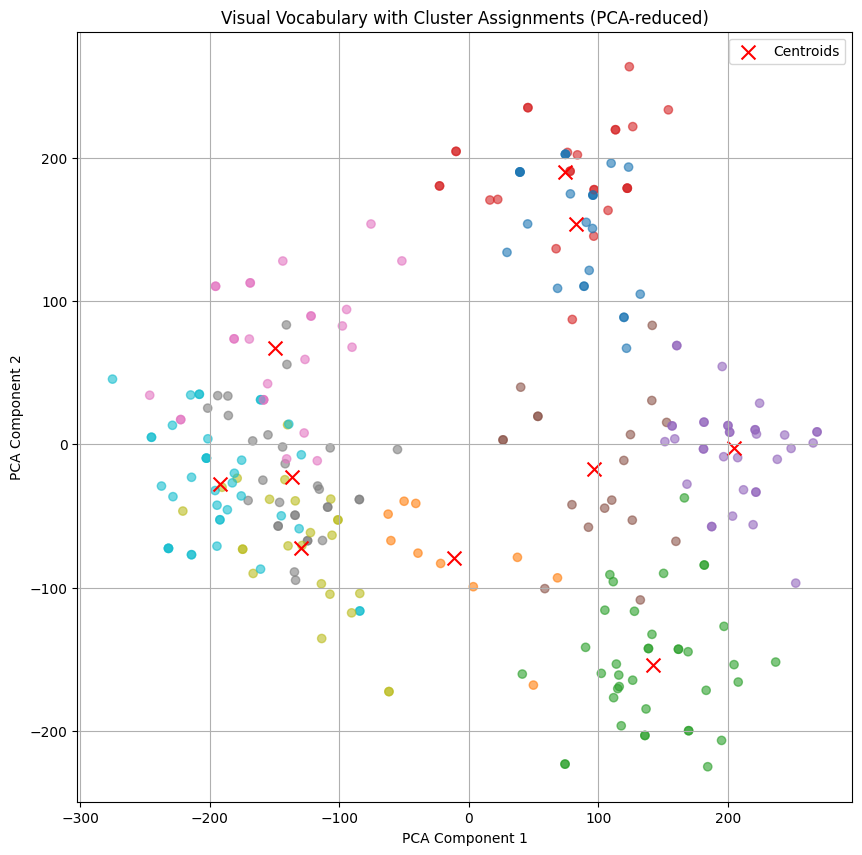

WARNING clustering 35541 points to 1000 centroids: please provide at least 39000 training points


Clustering 35541 points in 32D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (1.56 s, search 1.54 s): objective=3.03845e+09 imbalance=1.144 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (3.12 s, search 3.08 s): objective=3.03969e+09 imbalance=1.151 nsplit=0       
Outer iteration 2 / 5
  Iteration 19 (4.67 s, search 4.62 s): objective=3.03505e+09 imbalance=1.140 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 19 (6.19 s, search 6.12 s): objective=3.03848e+09 imbalance=1.156 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (7.85 s, search 7.77 s): objective=3.03714e+09 imbalance=1.138 nsplit=0       


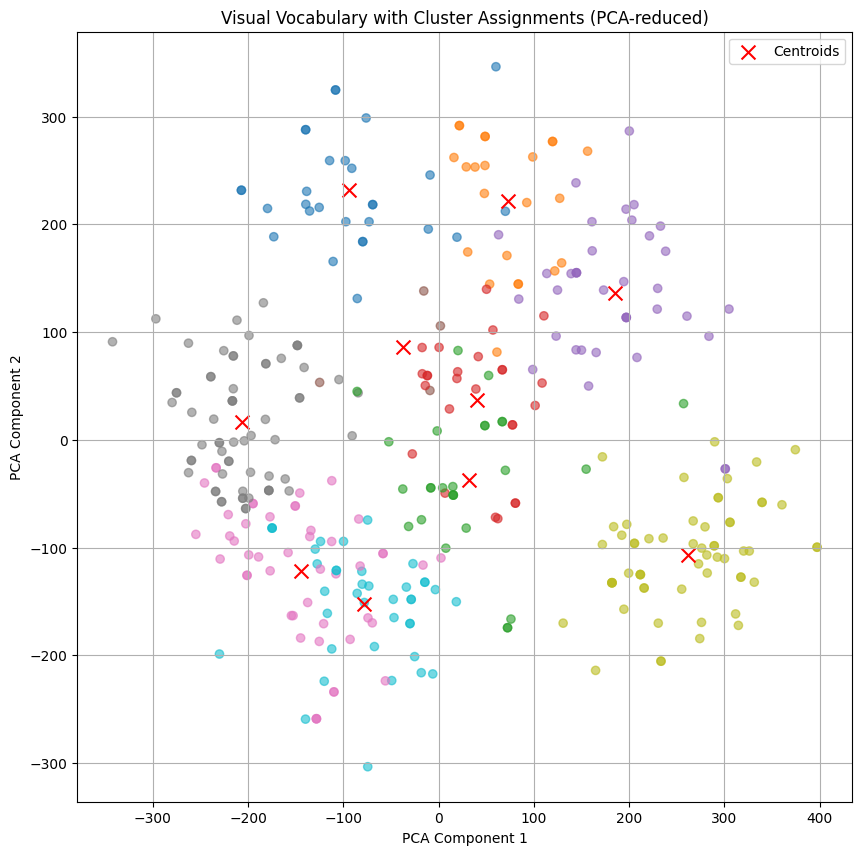

{'sift_0.3': array([[ 3.7333336, 13.400001 ,  5.1333337, ...,  7.0000005,  3.0000002,
          3.6666667],
        [23.928572 , 16.107143 ,  3.7857144, ..., 10.750001 ,  8.928572 ,
          6.4285717],
        [35.25     , 28.083334 , 38.916668 , ..., 16.5      ,  3.1666667,
          7.166667 ],
        ...,
        [33.52174  , 15.086957 ,  9.086957 , ..., 43.304348 , 28.695652 ,
         19.043478 ],
        [21.428572 ,  5.4285717,  5.1428576, ..., 14.571429 , 14.142858 ,
         19.142859 ],
        [ 5.375    , 18.875    ,  6.75     , ..., 36.625    , 32.375    ,
         16.75     ]], dtype=float32),
 'orb_0.3': array([[172.61539 , 122.46154 , 143.      , ..., 188.69232 ,  63.269234,
         155.88463 ],
        [174.66667 , 138.73334 ,  82.46667 , ...,  83.333336,  55.26667 ,
          65.      ],
        [110.06667 , 206.00002 ,  49.666668, ..., 172.26668 , 203.13335 ,
          88.333336],
        ...,
        [120.458336, 190.16667 , 152.91667 , ...,  66.16667 , 160.1666

In [4]:
# YOUR CODE HERE
from sklearn.decomposition import PCA
import faiss

# extracts features of an image given a specific method like orb etc. 
# returns the features as array of tuples e.g. [(1,1), (2,1), ...]
def extract_features(images, method):
    features = []
    for img in images:
        img = (img * 255).astype(np.uint8) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        if method == 'sift':
            _, descriptors = detect_keypoints_sift(img)
        elif method == 'orb':
            _, descriptors = detect_keypoints_orb(img)
        if descriptors is not None and len(descriptors) > 0:
            features.extend(descriptors)  
    
    features = np.array(features)

    return features

# applies faiss kmeans
def kmeans(features, num_clusters=1000, number_redos=5, number_iterations=20):
    d = features.shape[1]
    kmeans = faiss.Kmeans(d=d, k=num_clusters, niter=number_iterations, nredo=number_redos, verbose=True)
    kmeans.train(features)

    _, assignments = kmeans.index.search(features, 1) 
    return kmeans.centroids, assignments.flatten()

# visualizes clusters lol.
# they look weird though. If you use sift as method the clusters look better. But with the other methods it is weird. 
def visualize_clusters(features, centroids, assignments):
    if len(features) == 0:
        print("No features to visualize.")
        return None
    pca = PCA(n_components=2)
    try:
        reduced_features = pca.fit_transform(features)
        reduced_centroids = pca.transform(centroids)  
    except Exception as e:
        print("PCA failed:", e)
        return None

    plt.figure(figsize=(10, 10))

    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=assignments, cmap='tab10', alpha=0.6)
    
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c="red", marker='x', s=100, label="Centroids")
    
    plt.title('Visual Vocabulary with Cluster Assignments (PCA-reduced)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.legend()
    plt.show()

# filters the points belonging the each cluster when we only want to visualize a subset e.g. first 10 clusters
def get_relevant_points(features, assignments, clusters_wanted):
    filtered_features = []
    filtered_assignments = []
    
    for feature, assignment in zip(features, assignments):
        if assignment in clusters_wanted:
            filtered_features.append(feature)
            filtered_assignments.append(assignment)
    
    return filtered_features, filtered_assignments

# gets the centroids - returns a dict - e.g.{"orb_.3":[(1.2), ...], "sift_.5":[...]} 
def get_centroids(train_images, percentages = [.3, .5], methods = ["orb", "sift"], num_centroids=1000, visualize=True, number_of_clusters_to_display=10, number_redos_kmeans=5, number_iterations_kmeans=20):
    centroids_dict = {}
    for percent in percentages:
        if percent < 1:
            num_images = int(len(train_images) * percent)
            sampled_images = [get_random_picture()[0] for _ in range(num_images)]
        else:
            try:
                sampled_images = [image.numpy() for image in train_images]
            except:
                sampled_images = train_images
        for method in methods:
            features = extract_features(sampled_images, method)
            centroids, assignments = kmeans(features, num_centroids, number_redos=number_redos_kmeans, number_iterations=number_iterations_kmeans)  


            if visualize:
                features_filtered, assignments_filtered = get_relevant_points(features, assignments, list(range(number_of_clusters_to_display)))
                visualize_clusters(features_filtered, centroids[:number_of_clusters_to_display], assignments_filtered)
            centroids_dict[f"{method}_{percent}"] = centroids
    return centroids_dict

get_centroids(train_images, methods=["sift", "orb"])

<a id="section-4"></a>
### **Section 4: Encoding Train Image Features (3 points)**

In this section, the task is to encode image features using the visual vocabulary created earlier. Each image will be represented as a histogram of visual words, reflecting the frequency of each visual word in the image. This representation will allow for comparing images based on their visual content.

To encode an image, identify the nearest visual word (cluster center) for each feature descriptor extracted from the image. Construct a histogram that counts the occurrences of each visual word within the image. The final output will be a collection of histograms, one for each image, where each histogram serves as the feature representation of that image. Once again,  Use the two different extraction techniques you implemented to extract descriptors from the images. Then, encode the images using the visual vocabulary created in the previous step.

**Hint:** Utilize the `faiss` library for efficient nearest neighbor search when assigning each descriptor to the nearest cluster center in the visual dictionary. If `faiss` is not available, consider using other libraries, such as `scikit-learn`, for this step. Once the histograms are obtained, they will be used for further tasks, such as training a classifier. For now, perform the encoding only for the training set.

WARNING clustering 17338 points to 1000 centroids: please provide at least 39000 training points


Clustering 17338 points in 128D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (1.79 s, search 1.77 s): objective=1.18779e+09 imbalance=1.238 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (3.57 s, search 3.52 s): objective=1.187e+09 imbalance=1.226 nsplit=0         
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (5.31 s, search 5.24 s): objective=1.18634e+09 imbalance=1.217 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 19 (7.06 s, search 6.96 s): objective=1.18759e+09 imbalance=1.233 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (9.04 s, search 8.91 s): objective=1.18555e+09 imbalance=1.224 nsplit=0       
Objective improved: keep new clusters


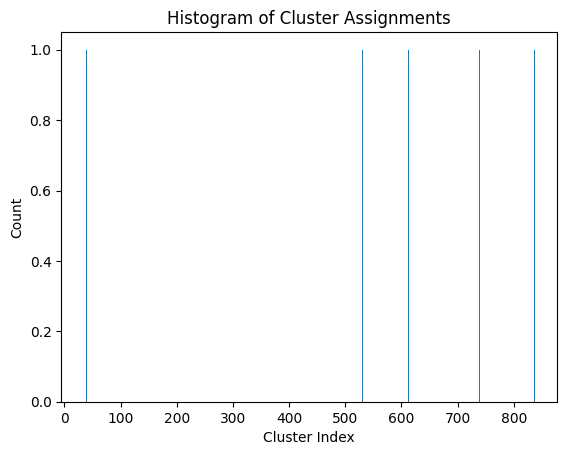

{35: 1, 39: 1, 149: 1, 181: 1, 313: 1, 330: 1, 531: 1, 613: 1, 739: 1, 837: 1}

In [5]:
# YOUR CODE HERE

# e.g. we have 1000 centroids, and now we "encode" our pictures using these centroids. Meaning for every descriptor we find in a picture, we identify 
# the nearest centroid e.g. centroid number 5. Then we count how many times each centroid was closest and plot it as histogram.
def get_histogram(centroids, img, method, visualize = True):
    
    d = centroids.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(centroids)
    
    features = extract_features([img], method)  
    features = np.array(features).astype('float32')  

    indices = []  

    error_counter = 0
    for keypoint in features:
        try:
            k = 1  
            keypoint = keypoint.reshape(1, -1).astype('float32')
            _, cluster_index = index.search(keypoint, k) 
            indices.append(cluster_index[0][0]) 
        except Exception as e:
            error_counter += 1
            print(f"Error finding nearest cluster for keypoint of shape {keypoint.shape} used method {method} -> {keypoint}.\n")
            print(f"Error type: {type(e).__name__}")
            print(f"Error message: {e}")
            if error_counter > 3:
                return False
            continue

    indices = np.array(indices)
    unique, counts = np.unique(indices, return_counts=True) 
    if visualize:
        plt.bar(unique, counts)
        plt.title("Histogram of Cluster Assignments")
        plt.xlabel("Cluster Index")
        plt.ylabel("Count")
        plt.show()

    histogram = dict(zip(unique, counts))
    
    return histogram
    


centroids_dict = get_centroids(train_images, visualize=False, percentages=[.3], methods=["sift"])
img = get_random_picture()[0]
get_histogram(centroids_dict[list(centroids_dict.keys())[0]], img, method="sift")


<a id="section-5"></a>
### **Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)**

In this section, the task is to visualize the Bag of Visual Words for each class using the histograms generated in the previous step. The goal is to plot the mean histogram of visual words for each class, showing the distribution of visual words across the different categories in the training set.

Use the two different extraction techniques you implemented for this visualization. For each technique, calculate the mean histogram for each class and create a bar plot to display these histograms. Ensure that the plots are labeled clearly with the class names and feature descriptor types.

Clustering 59239 points in 128D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.01 s
Outer iteration 0 / 5
  Iteration 19 (5.83 s, search 5.76 s): objective=4.3727e+09 imbalance=1.058 nsplit=0        
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (11.51 s, search 11.38 s): objective=4.37593e+09 imbalance=1.067 nsplit=0       
Outer iteration 2 / 5
  Iteration 19 (17.23 s, search 17.03 s): objective=4.37417e+09 imbalance=1.058 nsplit=0       
Outer iteration 3 / 5
  Iteration 19 (23.11 s, search 22.83 s): objective=4.37709e+09 imbalance=1.055 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (28.95 s, search 28.60 s): objective=4.37624e+09 imbalance=1.062 nsplit=0       
Clustering 70719 points in 32D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (2.97 s, search 2.94 s): objective=6.34529e+09 imbalance=1.053 nsplit=0       
Objective improved: keep new clusters
Outer iterati

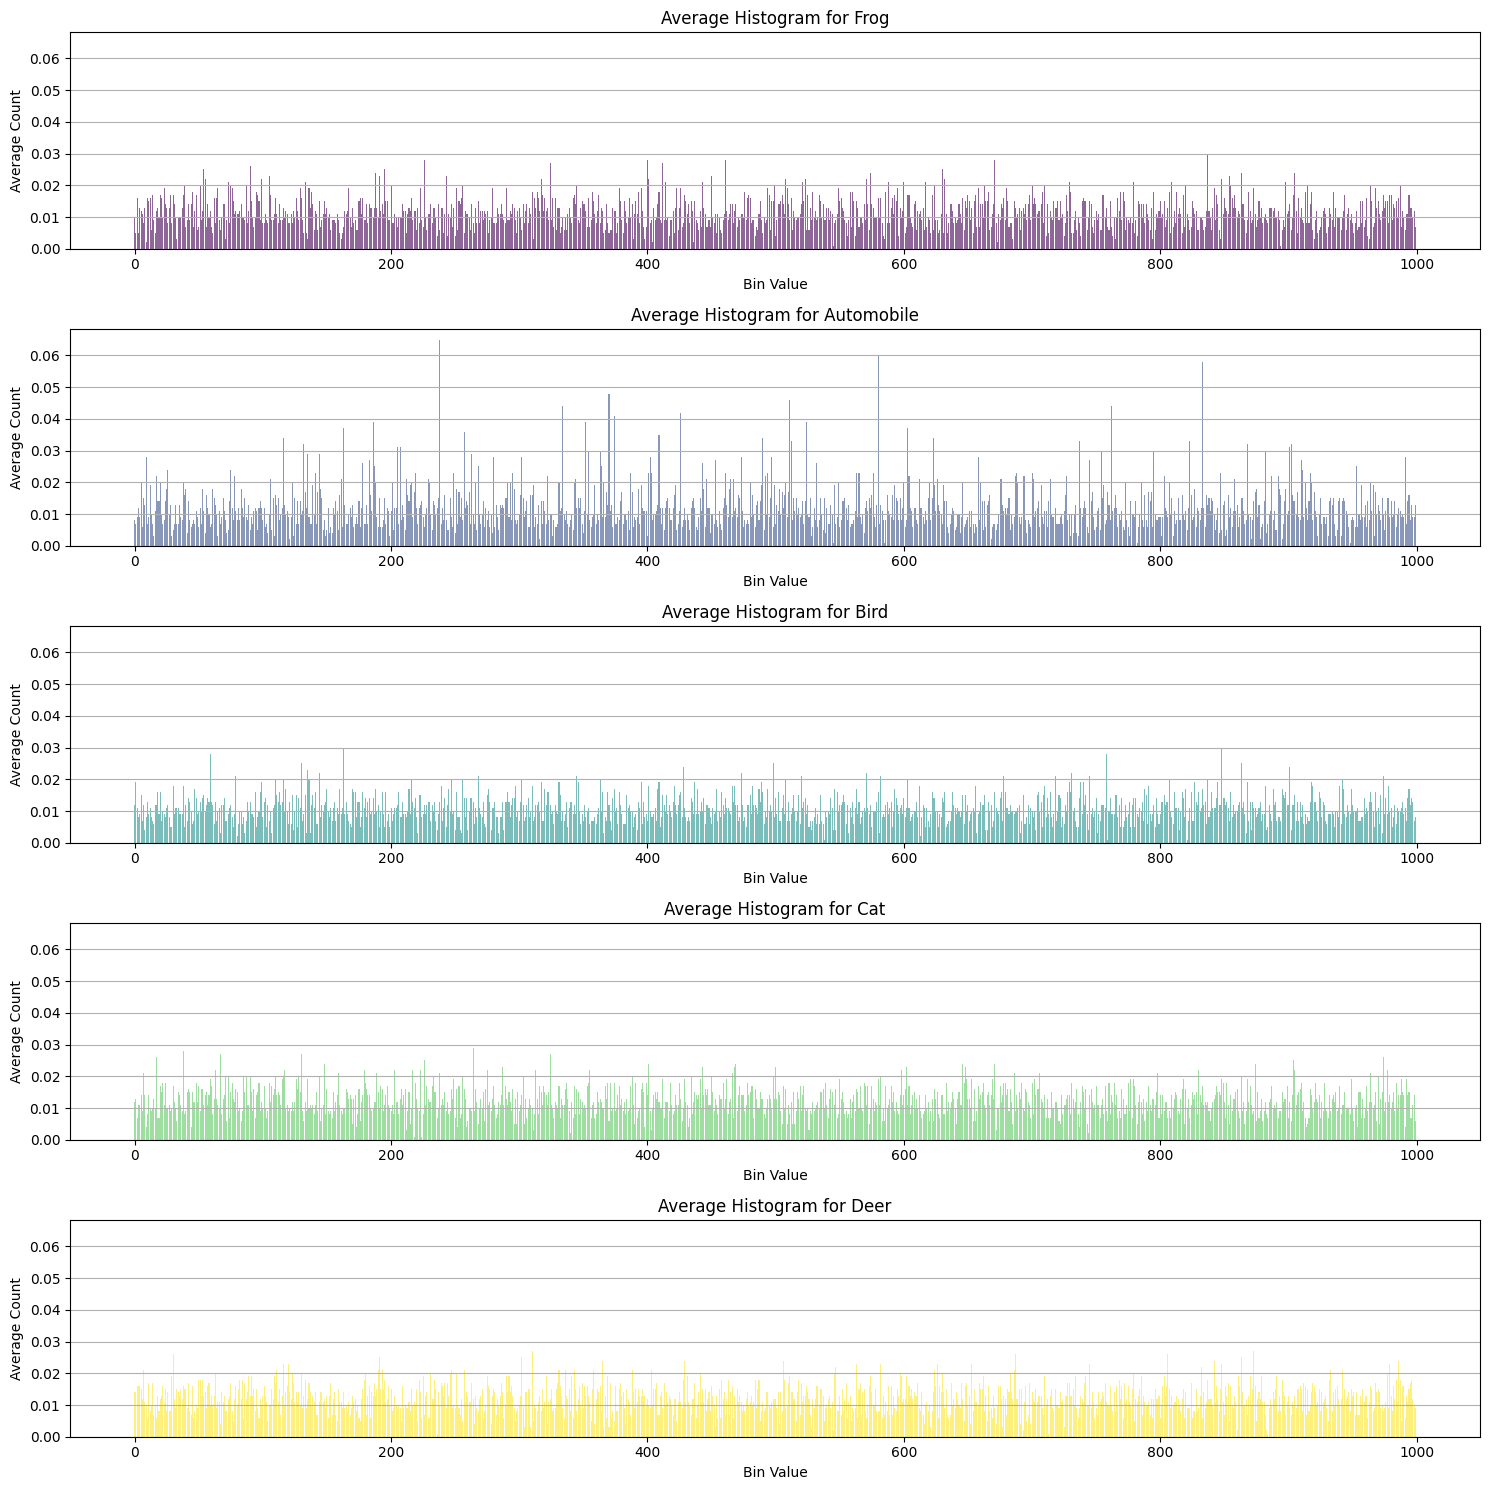

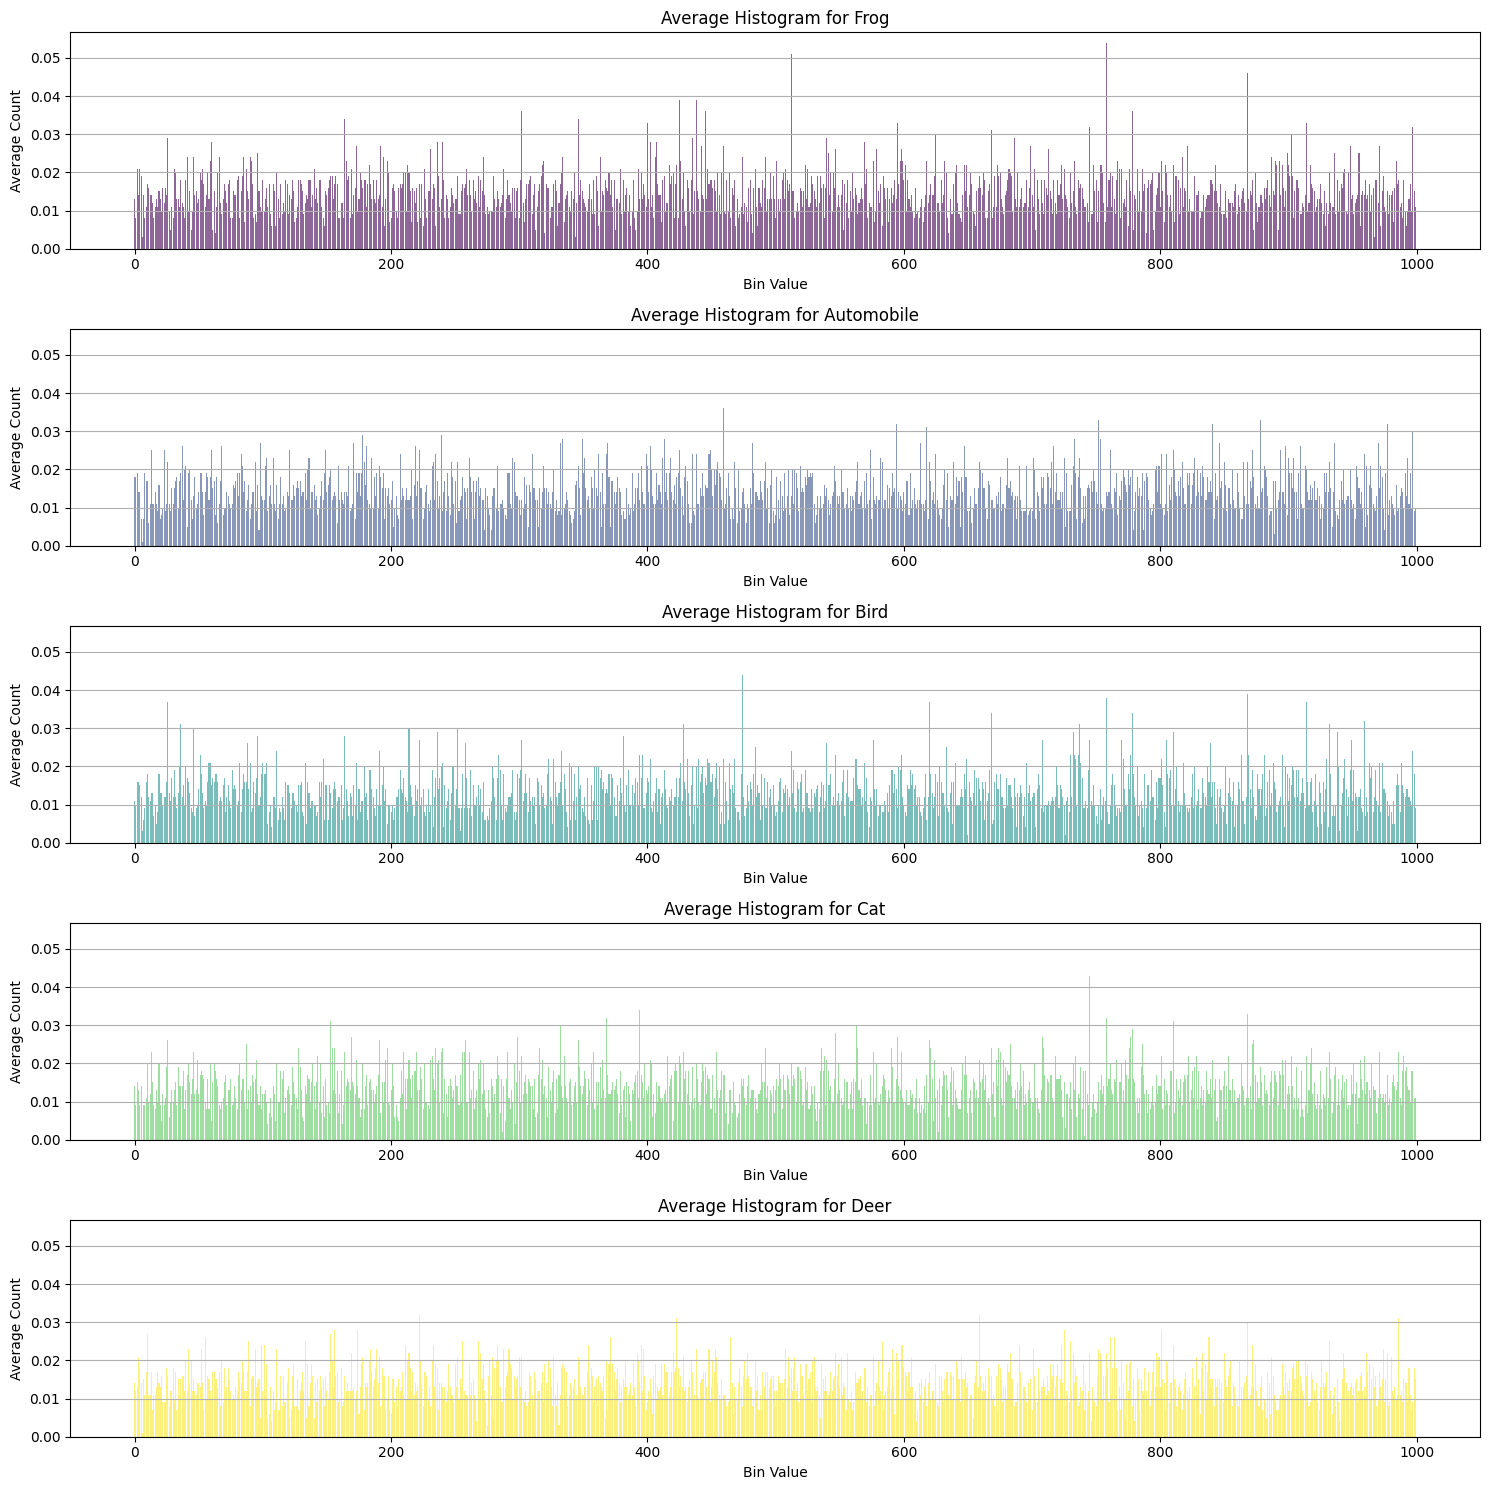

{'Frog': {91: 0.023,
  118: 0.018,
  414: 0.01,
  430: 0.006,
  431: 0.018,
  439: 0.015,
  491: 0.016,
  510: 0.015,
  609: 0.016,
  632: 0.023,
  644: 0.008,
  650: 0.011,
  671: 0.019,
  726: 0.014,
  759: 0.011,
  814: 0.018,
  865: 0.016,
  921: 0.01,
  283: 0.015,
  379: 0.021,
  384: 0.016,
  393: 0.021,
  473: 0.011,
  543: 0.02,
  579: 0.026,
  606: 0.014,
  684: 0.019,
  780: 0.014,
  847: 0.017,
  866: 0.012,
  951: 0.009,
  41: 0.024,
  47: 0.014,
  69: 0.013,
  103: 0.016,
  107: 0.006,
  212: 0.01,
  285: 0.011,
  335: 0.007,
  354: 0.013,
  417: 0.022,
  419: 0.019,
  512: 0.051,
  594: 0.013,
  616: 0.011,
  821: 0.027,
  911: 0.012,
  944: 0.021,
  11: 0.016,
  27: 0.01,
  222: 0.017,
  290: 0.013,
  323: 0.016,
  601: 0.022,
  808: 0.014,
  881: 0.016,
  908: 0.016,
  946: 0.009,
  38: 0.011,
  70: 0.017,
  133: 0.012,
  164: 0.034,
  279: 0.01,
  292: 0.014,
  341: 0.015,
  383: 0.014,
  388: 0.01,
  501: 0.023,
  675: 0.02,
  942: 0.016,
  969: 0.018,
  48: 0.015,
 

In [6]:
from collections import defaultdict


# here we just calculate the mean histogram per class.
def get_mean_histogram(centroids, train_images, train_labels, visualize = True, method="sift"):
    classes = {'Frog': 0, 'Automobile': 1, 'Bird': 2, 'Cat': 3, 'Deer': 4}
    
    histogram_sums = {class_name: defaultdict(int) for class_name in classes}
    class_counts = {class_name: 0 for class_name in classes}

    for class_name, class_index in classes.items():
        matching_indices = [i.item() for i in torch.where(train_labels == class_index)[0]]
        
        for index in matching_indices:
            img = train_images[index].numpy()
            
            histogram = get_histogram(centroids, img, visualize=False, method=method)
            
            for bin_value, count in histogram.items():
                histogram_sums[class_name][bin_value] += count
            
            class_counts[class_name] += 1

    average_histograms = {}
    for class_name in classes:
        total_images = class_counts[class_name]
        if total_images > 0:
            avg_histogram = {bin_value: count / total_images for bin_value, count in histogram_sums[class_name].items()}
            average_histograms[class_name] = avg_histogram
        else:
            average_histograms[class_name] = {}

    if visualize:
        num_classes = len(average_histograms)
        bin_labels = list(average_histograms.values())[0].keys() 

        fig, axes = plt.subplots(num_classes, 1, figsize=(15, 15), sharey=True)

        colors = plt.cm.viridis(np.linspace(0, 1, num_classes))  

        for i, (class_name, avg_histogram) in enumerate(average_histograms.items()):
            counts = [avg_histogram.get(bin_value, 0) for bin_value in bin_labels]
            
            axes[i,].bar(bin_labels, counts, alpha=0.6, color=colors[i])
            
            axes[i,].set_title(f'Average Histogram for {class_name}')
            axes[i,].set_xlabel('Bin Value')
            axes[i,].set_ylabel('Average Count')
            axes[i,].grid(axis='y')

        plt.tight_layout()
        plt.show()



    return average_histograms

centroids_dict = get_centroids(train_images, visualize=False, percentages=[1], methods=["sift", "orb"])
get_mean_histogram(centroids_dict["sift_1"], train_images, train_labels, method="sift")
get_mean_histogram(centroids_dict["orb_1"], train_images, train_labels, method="orb")


<a id="section-6"></a>
### **Section 6: Encoding Test Image Features (0 points)**

In this section, the task is to encode the test image features using the visual vocabulary created from the training set. Similar to the previous encoding step, each test image will be represented as a histogram of visual words, which will then be used for evaluating classification performance.

Use the same two feature extraction techniques you selected earlier. Extract keypoints and descriptors for the test images, then encode these images using the visual vocabulary. This will allow you to compare the encoded features of test images against those of the training set.

**Hint:** Reuse the functions developed earlier for extracting keypoints, descriptors, and encoding images. Ensure that you use the visual vocabulary constructed with the training images for consistency.

In [7]:

# as our get_histogram function only returns the cluster indices that accualy occur e.g 5:10 which means centroid 5 occurs 10 times
# we need to create a feature vector that is the same for each image. Hence, we create a vector of lenght 1000 
# where there are 0s if a centroid does not occur. 
# converts histogram of format {12:value, 15:value, ..} to e.g. {0:value, 1:0, 2:0, 3:4,  .., 999:0} for each cluster
def histogram_to_feature_vector(histogram, max_bins=1000):
    feature_vector = np.zeros(max_bins)  
    for bin_value, count in histogram.items():
        if bin_value < max_bins:
            feature_vector[bin_value] = count 
    return feature_vector

def extract_features_from_histograms(histograms):
    features = []
    for histogram in histograms:
        feature_vector = histogram_to_feature_vector(histogram)
        features.append(feature_vector)
    return np.array(features) 

def create_feature_vectors(images, centroids, method):
    histograms = []
    error_counter = 0
    for image in images:
        img_histogram = get_histogram(centroids, image, visualize=False, method=method)
        if img_histogram == False:
            error_counter += 1
            if error_counter > 3:
                print(img_histogram)
                print(f"Too many errors while creating feature vectors. Last image was {image.shape} with centroids {centroids.shape}.")
                break
        else:
            histograms.append(img_histogram)

    feature_array = extract_features_from_histograms(histograms)
    return feature_array



<a id="section-7"></a>
### **Section 7: Training the Classifiers (5 points)**

In this section, the task is to create two one-vs-rest (OvR) SVM classifiers using the 50% of the training data that was **not** used for creating the visual dictionary. This ensures that the classifiers are trained on a different subset of data, providing a more robust evaluation of the visual vocabulary's effectiveness.

For each of the two selected feature extraction techniques, create one-vs-rest classifiers for all classes. For now, use default parameter values when training the classifiers; you will experiment with different hyperparameters in later steps.

**Note:** Training an OvR classifier can take around 5 to 7 minutes. Therefore, it's advisable to first test your code with a smaller subset of the training data to verify that your implementation works correctly before running it on the full dataset.

In [15]:
# YOUR CODE HERE

import numpy as np
import torch
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


def get_predictor(train_images, train_labels, centroids, method="sift", kernel="linear", train_on_subset=False, subset_size=.5, print_extra_test_results=False, C=1):
    train_on_subset = False
    if train_on_subset:
        train_images_section_7, unused_images, train_labels_section_7, unused_labels = train_test_split(
            train_images, train_labels, train_size=subset_size, random_state=42
        )
        unused_images = np.array([image.numpy() for image in unused_images])
    else:
        train_images_section_7 = train_images.clone()
        train_labels_section_7 = train_labels.clone()


    train_images_section_7 = np.array([image.numpy() for image in train_images_section_7])

    features_1 = create_feature_vectors(train_images_section_7, centroids, method=method)

    ovr_svm_1 = OneVsRestClassifier(svm.SVC(kernel=kernel, C=C))  

    ovr_svm_1.fit(features_1, train_labels_section_7)

    if train_on_subset and print_extra_test_results:

        unused_features_1 = create_feature_vectors(unused_images, centroids, method=method)

        predictions_1 = ovr_svm_1.predict(unused_features_1)

        print("Classification Report for Features 1:\n", classification_report(unused_labels, predictions_1))

    return ovr_svm_1

#centroids_dict = get_centroids(train_images, [.3], ["sift"], False)
#centroids = centroids_dict["sift_1"]
#predictor = get_predictor(train_images, train_labels, centroids, "sift", "linear", True, .5)
        


<a id="section-8"></a>
### **Section 8: Evaluating the Classifiers (12 points)**

In this section, you will evaluate the performance of your one-vs-rest (OvR) SVM classifiers on the test data. The goal is to classify each test image using each binary classifier and rank the images based on the classification scores, resulting in a ranked list of images for each class. Ideally, images belonging to the target class should appear at the top of the respective list. To conduct this evaluation, use the test image histograms generated earlier for the two selected feature extraction techniques. Classify each test image with each classifier, rank them based on their confidence scores, and then compute the Mean Average Precision (mAP) across all classes. The mAP for a single class $c$ is defined as:

$
\text{mAP}_c = \frac{1}{m_c} \sum_{i=1}^{n} \frac{f_c(x_i)}{i}
$

where:
- $n$ is the total number of images ($n = 50 \times 5 = 250$),
- $m_c$ is the number of images of class $c$ ($m_c = 50$),
- $x_i$ is the $i^{th}$ image in the ranked list $X = \{ x_1, x_2, \dots, x_n \}$,
- $f_c$ is a function that returns the number of images of class $c$ in the first $i$ images if $x_i$ is of class $c$, and 0 otherwise.

For instance, if you are retrieving images of class "R" and the sequence of ranked images is $[R, R, T, R, T, T, R, T]$, then $n = 8$, $m_c = 4$, and:

$
AP = \frac{1}{4} \left( \frac{1}{1} + \frac{2}{2} + \frac{0}{3} + \frac{3}{4} + \frac{0}{5} + \frac{0}{6} + \frac{4}{7} + \frac{0}{8} \right).
$

In addition to the quantitative analysis, perform a qualitative analysis by visualizing the top-5 and bottom-5 ranked test images.

In [10]:
import numpy as np
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

def evaluate_ovr_svm_classifiers(ovr_classifier, X_test, y_test, class_names):

    n_classes = len(class_names)
    
    confidence_scores = ovr_classifier.decision_function(X_test)
    
    mean_average_precision = {}
    ranked_lists = {}

    for i, class_name in enumerate(class_names):
        class_scores = confidence_scores[:, i]
        
        ranked_indices = np.argsort(-class_scores)  
        ranked_lists[class_name] = ranked_indices
        
        y_true_binary = [int(y) for y in (y_test==1)]
        
        ap = average_precision_score(y_true_binary, class_scores)
        mean_average_precision[class_name] = ap
    
    return mean_average_precision, ranked_lists



In [144]:
class_names = ['Frog', 'Automobile', 'Bird', 'Cat', 'Deer']

X_test = test_images.clone()
X_test = [image.numpy() for image in X_test]
y_test = test_labels.clone()

#centroids_dict = get_centroids(train_images, [1], visualize=False, methods=["sift"], num_centroids=1500)
centroids = centroids_dict["sift_1"]

X_test_features = create_feature_vectors(X_test, centroids=centroids, method="sift")
predictor = get_predictor(train_images, train_labels, centroids, kernel="linear", method="sift")
mean_ap, ranked_images = evaluate_ovr_svm_classifiers(predictor, X_test_features, y_test, class_names)

print()
for class_name, ap in mean_ap.items():
    print(f"Class {class_name}: AP = {ap:.4f}")
print()
print(f"Mean AP of all classes: {sum(mean_ap.values())/5}")

In [143]:
class_names = ['Frog', 'Automobile', 'Bird', 'Cat', 'Deer']

X_test = test_images.clone()
X_test = [image.numpy() for image in X_test]
y_test = test_labels.clone()

#centroids_dict = get_centroids(train_images, [1], visualize=False, methods=["orb", "sift"], num_centroids=500, number_iterations_kmeans=15)
centroids = centroids_dict["orb_1"]

X_test_features = create_feature_vectors(X_test, centroids=centroids, method="orb")
predictor = get_predictor(train_images, train_labels, centroids, kernel="linear", method="orb")
mean_ap, ranked_images = evaluate_ovr_svm_classifiers(predictor, X_test_features, y_test, class_names)

print()
for class_name, ap in mean_ap.items():
    print(f"Class {class_name}: AP = {ap:.4f}")

print()
print(f"Mean AP of all classes: {sum(mean_ap.values())/5}")


Class Frog: AP = 0.2033
Class Automobile: AP = 0.2530
Class Bird: AP = 0.1895
Class Cat: AP = 0.1994
Class Deer: AP = 0.1933

Mean AP of all classes: 0.20769345478548865


In [21]:
ranked_images["Frog"].shape

(1000,)

<a id="section-9"></a>
### **Section 9: Hyperparameter Search (16 points)**

In this section, the task is to perform an extensive hyperparameter search to optimize the performance of your classifiers. You will experiment with various parameters, including the number of visual words (e.g., 500, 1000, 1500), different training subset sizes (e.g., 30%, 40%, 50%), SVM parameters (e.g., kernel types like 'linear' or 'rbf', regularization parameter $C$ values such as 0.1, 1, 10, and gamma settings like 'scale' or specific values such as 0.01, 0.001), and settings of the feature extractors (e.g., the number of keypoints or scale levels). Start by testing your code on the smallest subset to ensure it functions correctly before proceeding with a full hyperparameter search. Once validated, conduct the search using larger subsets and systematically iterate through the different parameter combinations, potentially using nested loops or grid search. Be sure to record the performance results for each combination to identify the best settings based on metrics like the Mean Average Precision (mAP).

In [11]:
centroids_dict_500 = get_centroids(train_images, [.4, .6, .8, 1], visualize=False, methods=["orb", "sift"], num_centroids=500, number_iterations_kmeans=20)
centroids_dict_1000 = get_centroids(train_images, [.4, .6, .8, 1], visualize=False, methods=["orb", "sift"], num_centroids=1000, number_iterations_kmeans=20)
centroids_dict_1500 = get_centroids(train_images, [.4, .6, .8, 1], visualize=False, methods=["orb", "sift"], num_centroids=1500, number_iterations_kmeans=20)

Clustering 28574 points in 32D to 500 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.80 s, search 0.78 s): objective=2.65524e+09 imbalance=1.094 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (1.52 s, search 1.49 s): objective=2.65652e+09 imbalance=1.091 nsplit=0       
Outer iteration 2 / 5
  Iteration 19 (2.24 s, search 2.20 s): objective=2.65293e+09 imbalance=1.097 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 19 (2.96 s, search 2.90 s): objective=2.65102e+09 imbalance=1.086 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 5
  Iteration 19 (3.67 s, search 3.61 s): objective=2.65741e+09 imbalance=1.099 nsplit=0       
Clustering 23626 points in 128D to 500 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (1.34 s, search 1.31 s): objective=1.80387e+09 imbalance=1.092 n

WARNING clustering 28439 points to 1000 centroids: please provide at least 39000 training points


  Iteration 19 (1.22 s, search 1.21 s): objective=2.39979e+09 imbalance=1.174 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (2.40 s, search 2.37 s): objective=2.39466e+09 imbalance=1.186 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (3.57 s, search 3.53 s): objective=2.39678e+09 imbalance=1.175 nsplit=0       
Outer iteration 3 / 5
  Iteration 19 (4.75 s, search 4.69 s): objective=2.39393e+09 imbalance=1.179 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 5
  Iteration 19 (6.02 s, search 5.95 s): objective=2.39563e+09 imbalance=1.162 nsplit=0       
Clustering 24137 points in 128D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5


WARNING clustering 24137 points to 1000 centroids: please provide at least 39000 training points


  Iteration 19 (2.38 s, search 2.35 s): objective=1.6914e+09 imbalance=1.198 nsplit=0        
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (4.73 s, search 4.67 s): objective=1.68838e+09 imbalance=1.200 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (7.09 s, search 7.00 s): objective=1.68979e+09 imbalance=1.199 nsplit=0       
Outer iteration 3 / 5
  Iteration 19 (9.42 s, search 9.30 s): objective=1.69148e+09 imbalance=1.203 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (11.84 s, search 11.69 s): objective=1.68619e+09 imbalance=1.184 nsplit=0       
Objective improved: keep new clusters
Clustering 42218 points in 32D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (1.96 s, search 1.94 s): objective=3.62539e+09 imbalance=1.143 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (3.75 s, search 3.71 s): objecti

WARNING clustering 35513 points to 1000 centroids: please provide at least 39000 training points


  Iteration 19 (3.46 s, search 3.43 s): objective=2.52321e+09 imbalance=1.171 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (6.85 s, search 6.77 s): objective=2.51859e+09 imbalance=1.162 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (10.23 s, search 10.11 s): objective=2.51814e+09 imbalance=1.148 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 19 (13.60 s, search 13.44 s): objective=2.52241e+09 imbalance=1.162 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (17.09 s, search 16.89 s): objective=2.5157e+09 imbalance=1.142 nsplit=0        
Objective improved: keep new clusters
Clustering 56410 points in 32D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (2.47 s, search 2.44 s): objective=4.87877e+09 imbalance=1.113 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Ite

WARNING clustering 28404 points to 1500 centroids: please provide at least 58500 training points


Clustering 28404 points in 32D to 1500 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (1.83 s, search 1.81 s): objective=2.23065e+09 imbalance=1.241 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (3.67 s, search 3.64 s): objective=2.23078e+09 imbalance=1.249 nsplit=0       
Outer iteration 2 / 5
  Iteration 19 (5.55 s, search 5.51 s): objective=2.22764e+09 imbalance=1.243 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 19 (7.36 s, search 7.30 s): objective=2.23077e+09 imbalance=1.240 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (9.19 s, search 9.12 s): objective=2.22646e+09 imbalance=1.237 nsplit=0       
Objective improved: keep new clusters
Clustering 23620 points in 128D to 1500 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5


WARNING clustering 23620 points to 1500 centroids: please provide at least 58500 training points


  Iteration 19 (3.51 s, search 3.48 s): objective=1.54167e+09 imbalance=1.273 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (7.02 s, search 6.96 s): objective=1.53915e+09 imbalance=1.261 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (10.47 s, search 10.38 s): objective=1.53682e+09 imbalance=1.262 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 19 (13.93 s, search 13.81 s): objective=1.54307e+09 imbalance=1.287 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (17.45 s, search 17.30 s): objective=1.54153e+09 imbalance=1.274 nsplit=0       


WARNING clustering 42265 points to 1500 centroids: please provide at least 58500 training points


Clustering 42265 points in 32D to 1500 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (2.78 s, search 2.76 s): objective=3.40391e+09 imbalance=1.185 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (5.48 s, search 5.43 s): objective=3.40264e+09 imbalance=1.194 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (8.22 s, search 8.16 s): objective=3.40274e+09 imbalance=1.196 nsplit=0       
Outer iteration 3 / 5
  Iteration 19 (11.36 s, search 11.27 s): objective=3.40351e+09 imbalance=1.189 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (13.92 s, search 13.81 s): objective=3.40372e+09 imbalance=1.190 nsplit=0       
Clustering 35593 points in 128D to 1500 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.01 s
Outer iteration 0 / 5


WARNING clustering 35593 points to 1500 centroids: please provide at least 58500 training points


  Iteration 19 (4.66 s, search 4.63 s): objective=2.38183e+09 imbalance=1.236 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (9.33 s, search 9.26 s): objective=2.38734e+09 imbalance=1.237 nsplit=0       
Outer iteration 2 / 5
  Iteration 19 (14.03 s, search 13.92 s): objective=2.382e+09 imbalance=1.213 nsplit=0         
Outer iteration 3 / 5
  Iteration 19 (18.66 s, search 18.52 s): objective=2.38274e+09 imbalance=1.223 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (23.45 s, search 23.27 s): objective=2.38508e+09 imbalance=1.236 nsplit=0       


WARNING clustering 56931 points to 1500 centroids: please provide at least 58500 training points


Clustering 56931 points in 32D to 1500 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (3.25 s, search 3.22 s): objective=4.64618e+09 imbalance=1.172 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (6.42 s, search 6.37 s): objective=4.6497e+09 imbalance=1.171 nsplit=0        
Outer iteration 2 / 5
  Iteration 19 (9.57 s, search 9.49 s): objective=4.64711e+09 imbalance=1.168 nsplit=0       
Outer iteration 3 / 5
  Iteration 19 (12.71 s, search 12.62 s): objective=4.6474e+09 imbalance=1.163 nsplit=0        
Outer iteration 4 / 5
  Iteration 19 (15.95 s, search 15.83 s): objective=4.65016e+09 imbalance=1.158 nsplit=0       
Clustering 47091 points in 128D to 1500 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.01 s
Outer iteration 0 / 5


WARNING clustering 47091 points to 1500 centroids: please provide at least 58500 training points


  Iteration 19 (6.04 s, search 6.00 s): objective=3.19199e+09 imbalance=1.184 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (12.09 s, search 12.01 s): objective=3.19871e+09 imbalance=1.192 nsplit=0       
Outer iteration 2 / 5
  Iteration 19 (18.18 s, search 18.04 s): objective=3.19552e+09 imbalance=1.195 nsplit=0       
Outer iteration 3 / 5
  Iteration 19 (24.21 s, search 24.03 s): objective=3.19849e+09 imbalance=1.191 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (30.31 s, search 30.09 s): objective=3.19692e+09 imbalance=1.198 nsplit=0       
Clustering 70719 points in 32D to 1500 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (3.95 s, search 3.92 s): objective=6.04399e+09 imbalance=1.072 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (7.91 s, search 7.85 s): objective=6.04548e+09 imbalance=1.077 nsplit=0       
Outer iteration 2 / 5
 

In [16]:
class_names = ['Frog', 'Automobile', 'Bird', 'Cat', 'Deer']

X_test = test_images.clone()
X_test = [image.numpy() for image in X_test]
y_test = test_labels.clone()

Cs = [.1, 1, 10]
kernels = ["linear", "rbf"]
methods = ["sift", "orb"]
percentages = [0.4, 0.6, 0.8, 1]

# Open a file for writing
with open("svm_evaluation_results_500.txt", "w") as f_out:
    for method in methods:
        for percentage in percentages:
            f_out.write("--------------------------------------------------------------------------\n")
            f_out.write(f"Testrun for 500 centroids and {method}_{percentage}\n")
            print(f"Testrun for 500 centroids and {method}_{percentage}")
            centroids = centroids_dict_500[f"{method}_{percentage}"]
            X_test_features = create_feature_vectors(X_test, centroids=centroids, method=method)
            
            for kernel in kernels:
                for C in Cs:
                    predictor = get_predictor(train_images, train_labels, centroids, kernel=kernel, method=method, C=C)
                    mean_ap, ranked_images = evaluate_ovr_svm_classifiers(predictor, X_test_features, y_test, class_names)
                    
                    # Write the AP results to the file
                    f_out.write(f"\nKernel: {kernel}, C: {C}\n")
                    for class_name, ap in mean_ap.items():
                        f_out.write(f"Class {class_name}: AP = {ap:.4f}\n")
                        print(f"Class {class_name}: AP = {ap:.4f}")
                    
                    f_out.write(f"\nMean AP of all classes: {sum(mean_ap.values())/5:.4f}\n")
                    print(f"Mean AP of all classes: {sum(mean_ap.values())/5:.4f}")
                    f_out.write("\n")


Testrun for 500 centroids and sift_0.4
Class Frog: AP = 0.1916
Class Automobile: AP = 0.4128
Class Bird: AP = 0.1805
Class Cat: AP = 0.1980
Class Deer: AP = 0.1742
Mean AP of all classes: 0.2314
Class Frog: AP = 0.2003
Class Automobile: AP = 0.3994
Class Bird: AP = 0.1733
Class Cat: AP = 0.2007
Class Deer: AP = 0.1781
Mean AP of all classes: 0.2304
Class Frog: AP = 0.2099
Class Automobile: AP = 0.4005
Class Bird: AP = 0.1725
Class Cat: AP = 0.1939
Class Deer: AP = 0.1939
Mean AP of all classes: 0.2342
Class Frog: AP = 0.1794
Class Automobile: AP = 0.4296
Class Bird: AP = 0.1895
Class Cat: AP = 0.1785
Class Deer: AP = 0.1706
Mean AP of all classes: 0.2295
Class Frog: AP = 0.1793
Class Automobile: AP = 0.4299
Class Bird: AP = 0.1895
Class Cat: AP = 0.1784
Class Deer: AP = 0.1708
Mean AP of all classes: 0.2296
Class Frog: AP = 0.1809
Class Automobile: AP = 0.4100
Class Bird: AP = 0.1879
Class Cat: AP = 0.1752
Class Deer: AP = 0.1694
Mean AP of all classes: 0.2247
Testrun for 500 centroids

In [17]:
class_names = ['Frog', 'Automobile', 'Bird', 'Cat', 'Deer']

X_test = test_images.clone()
X_test = [image.numpy() for image in X_test]
y_test = test_labels.clone()

Cs = [.1, 1, 10]
kernels = ["linear", "rbf"]
methods = ["sift", "orb"]
percentages = [0.4, 0.6, 0.8, 1]

# Open a file for writing
with open("svm_evaluation_results_1000.txt", "w") as f_out:
    for method in methods:
        for percentage in percentages:
            f_out.write("--------------------------------------------------------------------------\n")
            f_out.write(f"Testrun for 1000 centroids and {method}_{percentage}\n")
            print(f"Testrun for 1000 centroids and {method}_{percentage}")
            centroids = centroids_dict_1000[f"{method}_{percentage}"]
            X_test_features = create_feature_vectors(X_test, centroids=centroids, method=method)
            
            for kernel in kernels:
                for C in Cs:
                    predictor = get_predictor(train_images, train_labels, centroids, kernel=kernel, method=method, C=C)
                    mean_ap, ranked_images = evaluate_ovr_svm_classifiers(predictor, X_test_features, y_test, class_names)
                    
                    # Write the AP results to the file
                    f_out.write(f"\nKernel: {kernel}, C: {C}\n")
                    for class_name, ap in mean_ap.items():
                        f_out.write(f"Class {class_name}: AP = {ap:.4f}\n")
                        print(f"Class {class_name}: AP = {ap:.4f}")
                    
                    f_out.write(f"\nMean AP of all classes: {sum(mean_ap.values())/5:.4f}\n")
                    print(f"Mean AP of all classes: {sum(mean_ap.values())/5:.4f}")
                    f_out.write("\n")


Testrun for 1000 centroids and sift_0.4
Class Frog: AP = 0.1938
Class Automobile: AP = 0.3777
Class Bird: AP = 0.1820
Class Cat: AP = 0.1818
Class Deer: AP = 0.1772
Mean AP of all classes: 0.2225
Class Frog: AP = 0.1982
Class Automobile: AP = 0.3486
Class Bird: AP = 0.1829
Class Cat: AP = 0.1848
Class Deer: AP = 0.1776
Mean AP of all classes: 0.2184
Class Frog: AP = 0.1975
Class Automobile: AP = 0.3155
Class Bird: AP = 0.1905
Class Cat: AP = 0.1834
Class Deer: AP = 0.1743
Mean AP of all classes: 0.2123
Class Frog: AP = 0.1906
Class Automobile: AP = 0.3951
Class Bird: AP = 0.1915
Class Cat: AP = 0.1888
Class Deer: AP = 0.1799
Mean AP of all classes: 0.2292
Class Frog: AP = 0.1909
Class Automobile: AP = 0.3937
Class Bird: AP = 0.1915
Class Cat: AP = 0.1888
Class Deer: AP = 0.1799
Mean AP of all classes: 0.2289
Class Frog: AP = 0.1845
Class Automobile: AP = 0.3788
Class Bird: AP = 0.1847
Class Cat: AP = 0.1839
Class Deer: AP = 0.1808
Mean AP of all classes: 0.2225
Testrun for 1000 centroi

In [18]:
class_names = ['Frog', 'Automobile', 'Bird', 'Cat', 'Deer']

X_test = test_images.clone()
X_test = [image.numpy() for image in X_test]
y_test = test_labels.clone()

Cs = [.1, 1, 10]
kernels = ["linear", "rbf"]
methods = ["sift", "orb"]
percentages = [0.4, 0.6, 0.8, 1]

# Open a file for writing
with open("svm_evaluation_results_1500.txt", "w") as f_out:
    for method in methods:
        for percentage in percentages:
            f_out.write("--------------------------------------------------------------------------\n")
            f_out.write(f"Testrun for 1500 centroids and {method}_{percentage}\n")
            print(f"Testrun for 1500 centroids and {method}_{percentage}")
            centroids = centroids_dict_1500[f"{method}_{percentage}"]
            X_test_features = create_feature_vectors(X_test, centroids=centroids, method=method)
            
            for kernel in kernels:
                for C in Cs:
                    predictor = get_predictor(train_images, train_labels, centroids, kernel=kernel, method=method, C=C)
                    mean_ap, ranked_images = evaluate_ovr_svm_classifiers(predictor, X_test_features, y_test, class_names)
                    
                    # Write the AP results to the file
                    f_out.write(f"\nKernel: {kernel}, C: {C}\n")
                    for class_name, ap in mean_ap.items():
                        f_out.write(f"Class {class_name}: AP = {ap:.4f}\n")
                        print(f"Class {class_name}: AP = {ap:.4f}")
                    
                    f_out.write(f"\nMean AP of all classes: {sum(mean_ap.values())/5:.4f}\n")
                    print(f"Mean AP of all classes: {sum(mean_ap.values())/5:.4f}")
                    f_out.write("\n")


Testrun for 1500 centroids and sift_0.4
Class Frog: AP = 0.1673
Class Automobile: AP = 0.3736
Class Bird: AP = 0.1987
Class Cat: AP = 0.1667
Class Deer: AP = 0.1925
Mean AP of all classes: 0.2198
Class Frog: AP = 0.1706
Class Automobile: AP = 0.3328
Class Bird: AP = 0.1961
Class Cat: AP = 0.1724
Class Deer: AP = 0.1939
Mean AP of all classes: 0.2131
Class Frog: AP = 0.1724
Class Automobile: AP = 0.3184
Class Bird: AP = 0.1956
Class Cat: AP = 0.1773
Class Deer: AP = 0.1916
Mean AP of all classes: 0.2111
Class Frog: AP = 0.1639
Class Automobile: AP = 0.3934
Class Bird: AP = 0.2060
Class Cat: AP = 0.1731
Class Deer: AP = 0.1951
Mean AP of all classes: 0.2263
Class Frog: AP = 0.1638
Class Automobile: AP = 0.3980
Class Bird: AP = 0.2061
Class Cat: AP = 0.1731
Class Deer: AP = 0.1951
Mean AP of all classes: 0.2272
Class Frog: AP = 0.1659
Class Automobile: AP = 0.3503
Class Bird: AP = 0.1924
Class Cat: AP = 0.1733
Class Deer: AP = 0.2017
Mean AP of all classes: 0.2167
Testrun for 1500 centroi

In [29]:
import pandas as pd

df_500 = pd.read_pickle('parsed_data_500.pkl')
df_500["Number_Centroids"] = 500

df_1500 = pd.read_pickle('parsed_data_1500.pkl')
df_1500["Number_Centroids"] = 1500

df_1000 = pd.read_pickle('parsed_data_1000.pkl')
df_1000["Number_Centroids"] = 1000

df = pd.concat([df_500, df_1000, df_1500], ignore_index=True)


/tmp/ipykernel_59281/2811143521.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped, labels=grouped.index)


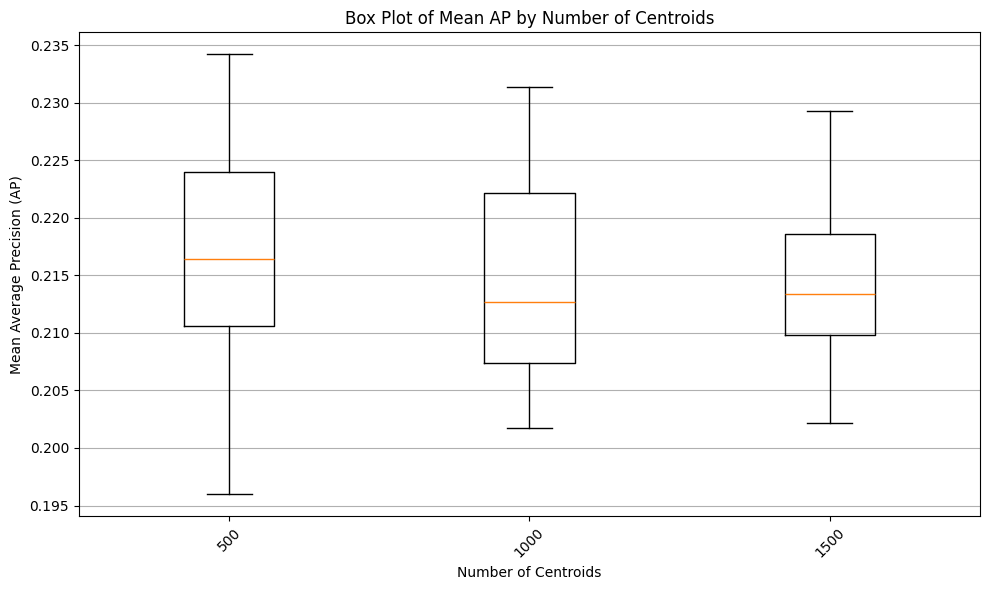

In [32]:
# Grouping the DataFrame by Number_Centroids
grouped = df.groupby('Number_Centroids')['Mean_AP'].apply(list)

# Creating box plots
plt.figure(figsize=(10, 6))
plt.boxplot(grouped, labels=grouped.index)
plt.title("Box Plot of Mean AP by Number of Centroids")
plt.xlabel("Number of Centroids")
plt.ylabel("Mean Average Precision (AP)")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<a id="section-10"></a>
### **Section 10: Using CLIP for Image Classification (5 points)**

**<span style="color:red">⚠️ NOTE: This section should NOT be included in the report. It is only meant to be completed in the code cells. The purpose of this task is to introduce you to a more state-of-the-art model (CLIP) compared to Bag of Visual Words (BoVW). Vision Transformers (ViT) will be covered in more detail in the Deep Learning 1 course next period!</span>**

In this section, you will use a pre-trained CLIP model for image classification. CLIP (Contrastive Language-Image Pretraining) is a vision-language transformer model trained on a large dataset of images and text. It consists of two main components: a Vision Transformer (ViT) and a text Transformer. The ViT encodes images by dividing them into patches (tokens), flattening each patch into a vector, and passing them through a sequence of Transformer layers to produce an encoded representation of the image.

For this task, you will use the visual transformer component of CLIP to extract encoded representations of the input images. While this is not the typical way to use CLIP (which involves encoding both images and text for similarity comparison), it provides an interesting application of this state-of-the-art model for image classification.

**To Install CLIP:**
```python
pip install git+https://github.com/openai/CLIP.git
```

**Additional Reading (if you're interested):**
- [OpenAI CLIP Overview](https://openai.com/clip)
- [Vision Transformer (ViT) Paper](https://arxiv.org/abs/2010.11929)
- [Tutorial on Vision Transformers](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)
- [UvA's Deep Learning Introduction to ViTs](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html)

First, create DataLoaders for both the training and test datasets by filtering the CIFAR-10 dataset to include only the selected classes: frog, automobile, bird, cat, and deer. Use a batch size of 16 for both DataLoaders, and resize the images to 224x224 to match the input size requirements for CLIP. Remember to normalize the images using the appropriate mean and standard deviation. Use a training set size of 1000 images per class and a test set size of 200 images per class.

In [ ]:
# YOUR CODE HERE

Next, we load a pre-trained CLIP model, which is a vision-language transformer designed to predict the text that describes an image and vice versa. The model consists of two components: a Vision Transformer (ViT) for encoding images and a text Transformer for encoding text. 

In [ ]:
import clip

# Setup the model and the preprocessor
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

To extract the visual tokens using the CLIP model, start by initializing two empty lists: one for storing the image features and another for the labels. Use `tqdm` to create a progress bar that tracks the extraction process over the DataLoader. Iterate through the DataLoader, extracting images and labels. Disable gradient computation, and then encode the images with `model.encode_image(images)`. Append the encoded features and labels to their respective lists. Remember, the output from the model will have the shape `(batch_size, 512)` due to batched processing, if your are using a single you should reshape the output to `(512,)` to remove the batch dimension.

In this example, we will use the class token as the visual representation of the image. The class token is a 512-dimensional vector that represents the image. We will use this vector to train a classifier to classify the images.

**Note:** The CLIP model is quite large and may take some time to extract features from the images. You can use the `tqdm` library to create a progress bar that shows the extraction progress. It is recommended to test the code with a smaller subset of images to ensure it functions correctly before running it on the full dataset. With the default batch size of 16 and a training set size of 1000 images, the extraction process may take a 10-20 minutes.

In [ ]:
# YOUR CODE HERE

In [ ]:
# Stack the (batched) visual tokens extracted from the images. The resulting shape will be (number_of_images, 512).
stacked_image_features = torch.cat(image_features_list)
stacked_target_labels = torch.cat(target_labels_list)

To train a classifier using the visual tokens, start by initializing an SVM classifier using `SVC()` from `scikit-learn`. You can play around with different hyperparameters such as kernel type, regularization parameter, and gamma to find the best configuration. Finally, use the `fit` method to train the classifier on the visual image features and labels.

In [ ]:
# YOUR CODE HERE

To evaluate the classifier, start by extracting the visual tokens from the test images using the same method applied to the training set. Loop through the test DataLoader, encode each batch of images using the model (e.g., `model.encode_image(images)`), and store the results in separate lists for the features and labels. After extracting all the features, stack them into a single tensor for both the features and labels. This process will prepare the test data for use in evaluating the classifier's performance.

In [ ]:
# YOUR CODE HERE

To evaluate the performance of your classifier, use the test set features you extracted earlier. First, generate predictions for the test set by passing the stacked test features into your trained classifier's `predict` method. Next, use the `classification_report` function from `sklearn.metrics` to create a detailed report that includes metrics such as precision, recall, and F1-score for each class. Finally, print the report to analyze how well your classifier performs across the different classes.

In [ ]:
# YOUR CODE HERE

<a id="section-x"></a>
### **Section X: Individual Contribution Report *(Mandatory)***

Because we want each student to contribute fairly to the submitted work, we ask you to fill out the textcells below. Write down your contribution to each of the assignment components in percentages. Naturally, percentages for one particular component should add up to 100% (e.g. 30% - 30% - 40%). No further explanation has to be given.

| Name | Contribution on Research | Contribution on Programming | Contribution on Writing |
| -------- | ------- | ------- | ------- |
|  | - % | - % | - % |
|  | - % | - % | - % |
|  | - % | - % | - % |
|  | - % | - % | - % |

### - End of Notebook -